<a href="https://colab.research.google.com/github/ryan-ribeiro/lia1_2024_2/blob/main/Entregas%20-%20Ryan%20Ribeiro/Desafio_Aula_12_Construindo_um_modelo_com_Keras/Desafio_Aula_12_Construindo_um_modelo_com_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projeto Ponta a Ponta - Construindo um Modelo com Keras - Dataset IMDB**

**Problema:** construir um modelo de Inteligência Artificial capaz de classificar sentimentos em reviews de filmes, considerando uma classificação binária (positivo/negativo).

**Não há mágica. Há matemática!** 🧙

**Fonte de dados**

O conjunto de dados [IMDB](https://keras.io/api/datasets/imdb/) é uma coleção de avaliações de filmes, amplamente utilizada para tarefas de Processamento de Linguagem Natural (NLP) no aprendizado de máquina. O dataset contém 25.000 reviews de treinamento e 25.000 de teste, já tokenizados e prontamente disponíveis no Keras.

##Fonte de dados

In [16]:
from keras import datasets, layers, models
import keras
import numpy as np

# Configurações do dataset
max_features = 20000  # Considera as 20.000 palavras mais frequentes
maxlen = 250  # Considera as primeiras 250 palavras de cada review

# Carrega o dataset IMDB
(reviews_treino, labels_treino), (reviews_teste, labels_teste) = datasets.imdb.load_data(num_words=max_features,
                                                                                         path="imdb.npz",
                                                                                         skip_top=0,
                                                                                         maxlen=None,
                                                                                         seed=113,
                                                                                         start_char=1,
                                                                                         oov_char=2,
                                                                                         index_from=3,)

# Mostra o tamanho dos dados de treino e teste
print(f"{len(reviews_treino)} sequências de treino")
print(f"{len(reviews_teste)} sequências de teste")

# Padroniza o comprimento das sequências para 250 palavras
x_train = keras.utils.pad_sequences(reviews_treino, maxlen=maxlen)
x_val = keras.utils.pad_sequences(reviews_teste, maxlen=maxlen)


25000 sequências de treino
25000 sequências de teste


##Visualizando as reviews


In [17]:
# Recupera o índice de palavras do dataset
word_index = keras.datasets.imdb.get_word_index()
# Reverte o índice de palavras para obter um dicionário que mapeia índices para palavras
indices_reviews_invertidos = {i + 3: word for word, i in word_index.items()}
indices_reviews_invertidos[1] = "[START]"
indices_reviews_invertidos[2] = "[OOV]"

# Decodifica a primeira sequência do dataset de treino
decoded_sequence = " ".join([indices_reviews_invertidos.get(i, "?") for i in reviews_treino[0]])
print(f"Exemplo de review decodificada:\n{decoded_sequence}")


Exemplo de review decodificada:
[START] this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert [OOV] is an amazing actor and now the same being director [OOV] father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the [OOV] of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these chil

Classes de palavras e Frequência de palavras

In [18]:
# Frequência das classes de palavras:
word_index = keras.datasets.imdb.get_word_index()

# Conta o número de índices
total_indices = len(word_index)

# print(f"Frequência das palavras: \n{word_index}\n")
print(f"Total de classes de palavras: {total_indices}")


Total de classes de palavras: 88584


##Construindo a Rede Neural com LSTMs Bidirecionais

In [19]:
# Criação do modelo
inputs = keras.Input(shape=(None,), dtype="int32")
x = layers.Embedding(max_features, 128)(inputs)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

# Compilação do modelo
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_3 (Embedding)              │ (None, None, 128)           │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, None, 128)           │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,757,761 (10.52 MB)

 Trainable params: 2,757,761 (10.52 MB)

 Non-trainable params: 0 (0.00 B)

## Treine o modelo

In [20]:
from keras.callbacks import EarlyStopping

# Definir o callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitora a perda no conjunto de validação
    patience=3,            # Para após 3 épocas sem melhora
    restore_best_weights=True # Restaura os pesos da melhor época
)


# Executa o treinamento
history = model.fit(x_train, labels_treino, batch_size=32, epochs=12, validation_data=(x_val, labels_teste), callbacks=[early_stopping])

Epoch 1/12
782/782 ━━━━━━━━━━━━━━━━━━━━ 547s 692ms/step - accuracy: 0.7537 - loss: 0.4855 - val_accuracy: 0.8591 - val_loss: 0.3349
Epoch 2/12
782/782 ━━━━━━━━━━━━━━━━━━━━ 550s 677ms/step - accuracy: 0.9116 - loss: 0.2307 - val_accuracy: 0.8622 - val_loss: 0.3368
Epoch 3/12
782/782 ━━━━━━━━━━━━━━━━━━━━ 562s 677ms/step - accuracy: 0.9535 - loss: 0.1320 - val_accuracy: 0.8683 - val_loss: 0.3862
Epoch 4/12
782/782 ━━━━━━━━━━━━━━━━━━━━ 561s 676ms/step - accuracy: 0.9691 - loss: 0.0892 - val_accuracy: 0.8596 - val_loss: 0.4017
Epoch 5/12
782/782 ━━━━━━━━━━━━━━━━━━━━ 529s 677ms/step - accuracy: 0.9815 - loss: 0.0572 - val_accuracy: 0.8586 - val_loss: 0.5112
Epoch 6/12
782/782 ━━━━━━━━━━━━━━━━━━━━ 527s 675ms/step - accuracy: 0.9865 - loss: 0.0409 - val_accuracy: 0.8534 - val_loss: 0.5580
Epoch 7/12
782/782 ━━━━━━━━━━━━━━━━━━━━ 549s 702ms/step - accuracy: 0.9915 - loss: 0.0264 - val_accuracy: 0.8442 - val_loss: 0.5441
Epoch 8/12
782/782 ━━━━━━━━━━━━━━━━━━━━ 528s 675ms/step - accuracy: 0.9911 -

Visualizando o treinamento

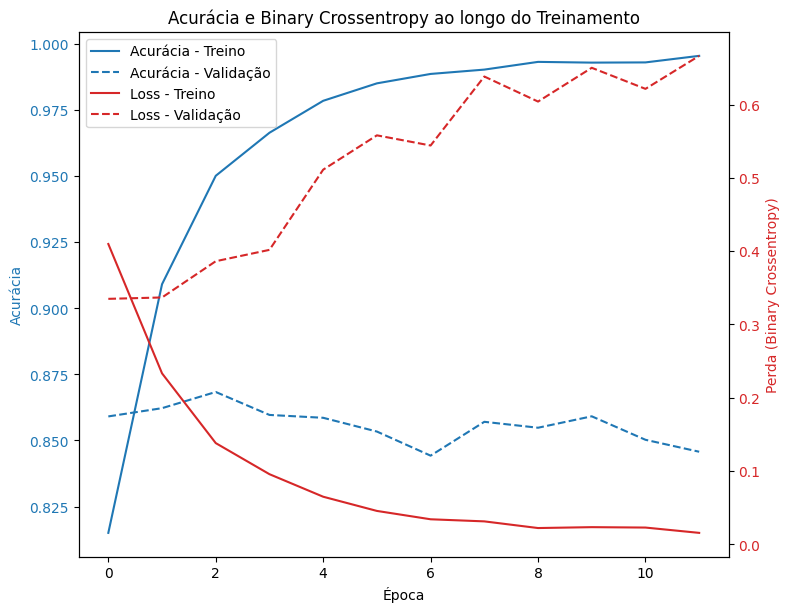

In [21]:
import matplotlib.pyplot as plt

# Função para visualizar o dashboard com accuracy e loss no mesmo gráfico, com legenda
def plot_combined_dashboard(history):
    # Cria a figura e o eixo
    fig, ax1 = plt.subplots(figsize=(8, 6))

    # Gráfico 1: Acurácia
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Acurácia', color='tab:blue')
    linha1, = ax1.plot(history.history['accuracy'], label='Acurácia - Treino', color='tab:blue')
    linha2, = ax1.plot(history.history['val_accuracy'], label='Acurácia - Validação', linestyle='--', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Cria um segundo eixo Y que compartilha o eixo X
    ax2 = ax1.twinx()
    ax2.set_ylabel('Perda (Binary Crossentropy)', color='tab:red')
    linha3, = ax2.plot(history.history['loss'], label='Loss - Treino', color='tab:red')
    linha4, = ax2.plot(history.history['val_loss'], label='Loss - Validação', linestyle='--', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # Título e exibição do gráfico
    fig.tight_layout()

    # Cria a legenda para as linhas
    linhas = [linha1, linha2, linha3, linha4]
    labels = ['Acurácia - Treino', 'Acurácia - Validação', 'Loss - Treino', 'Loss - Validação']
    plt.legend(linhas, labels, loc='upper left')

    plt.title('Acurácia e Binary Crossentropy ao longo do Treinamento')
    plt.show()

# Execute a função após o treinamento do modelo
plot_combined_dashboard(history)


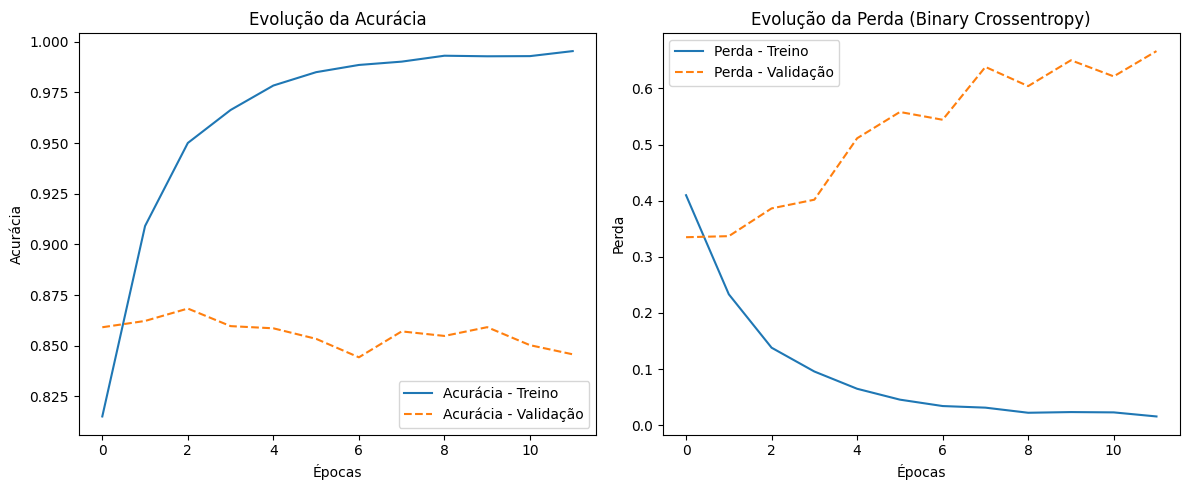

In [22]:
import matplotlib.pyplot as plt

# Função para exibir as métricas
def plot_metrics(history):
    # Gráfico de acurácia
    plt.figure(figsize=(12, 5))

    # Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Acurácia - Treino')
    plt.plot(history.history['val_accuracy'], label='Acurácia - Validação', linestyle='--')
    plt.title('Evolução da Acurácia')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()

    # Perda (Binary Crossentropy)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Perda - Treino')
    plt.plot(history.history['val_loss'], label='Perda - Validação', linestyle='--')
    plt.title('Evolução da Perda (Binary Crossentropy)')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Executa a função de visualização
plot_metrics(history)


**Previsão - Testar o modelo (Deploy)**

Agora vamos prever o sentimento de uma nova review com base em um exemplo do dataset.

In [33]:
# Seleciona uma review aleatória do conjunto de validação
print(f"Quantidade de reviews: {len(x_val)}")
review_index = 4  # Altere o índice para testar outras reviews
review = x_val[review_index]

# Faz a previsão
previsao = model.predict(np.expand_dims(review, axis=0))
classe_prevista = "Positiva" if previsao >= 0.5 else "Negativa"

# Decodifica a review selecionada
review_decoded = " ".join([indices_reviews_invertidos.get(i, "?") for i in reviews_teste[review_index]])

print(f"Review {review_index} decodificada:\n{review_decoded}\n")
print(f"Sentimento previsto: {classe_prevista} (Confiança: {previsao[0][0]:.2f})")


Quantidade de reviews: 25000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
Review 4 decodificada:
[START] like some other people wrote i'm a die hard mario fan and i loved this game br br this game starts slightly boring but trust me it's worth it as soon as you start your hooked the levels are fun and exiting they will hook you [OOV] your mind turns to mush i'm not kidding this game is also orchestrated and is beautifully done br br to keep this spoiler free i have to keep my mouth shut about details but please try this game it'll be worth it br br story 9 9 action 10 1 it's that good [OOV] 10 attention [OOV] 10 average 10

Sentimento previsto: Positiva (Confiança: 1.00)
